# Preparación del entorno

El primer paso es importar las librerías necesarias. En el caso de que la librería no esté disponible en el entorno virtual, podemos instalarla manualmente. Por ejemplo, haciendo uso de pip:

    !pip3 install hiddenlayer

Aclaración: Cualquier línea que comience con un signo de exclamación será ejecutada como un comando en una consola/terminal.

In [1]:
import os
from glob import glob

# Con fines de reproducibilidad, es importante fijar un valor para los generadores
# de números aleatorios.
RANDOM_SEED = 24

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import kurtosis, skew

# Lectura de los archivos de la competencia

In [2]:
data_path = "/kaggle/input/habla-imaginada-clasificacion-senales-EEG/"

df_train = pd.read_csv(f'{data_path}X_train/X_train')
df_test = pd.read_csv(f'{data_path}X_test/X_test')
y_train = pd.read_csv(f'{data_path}y_train.csv', header=None, names=['is_letter'])

In [3]:
channels = list(set([c[:2] for c in df_train.columns if len(c) < 5]))
channels.sort()

Exploramos los datos. Como se puede ver, las diferencias entre letras y comandos no son tan sencillas de ver a simple vista!

In [4]:
letter_sample = df_train[y_train.is_letter.values].head(1)

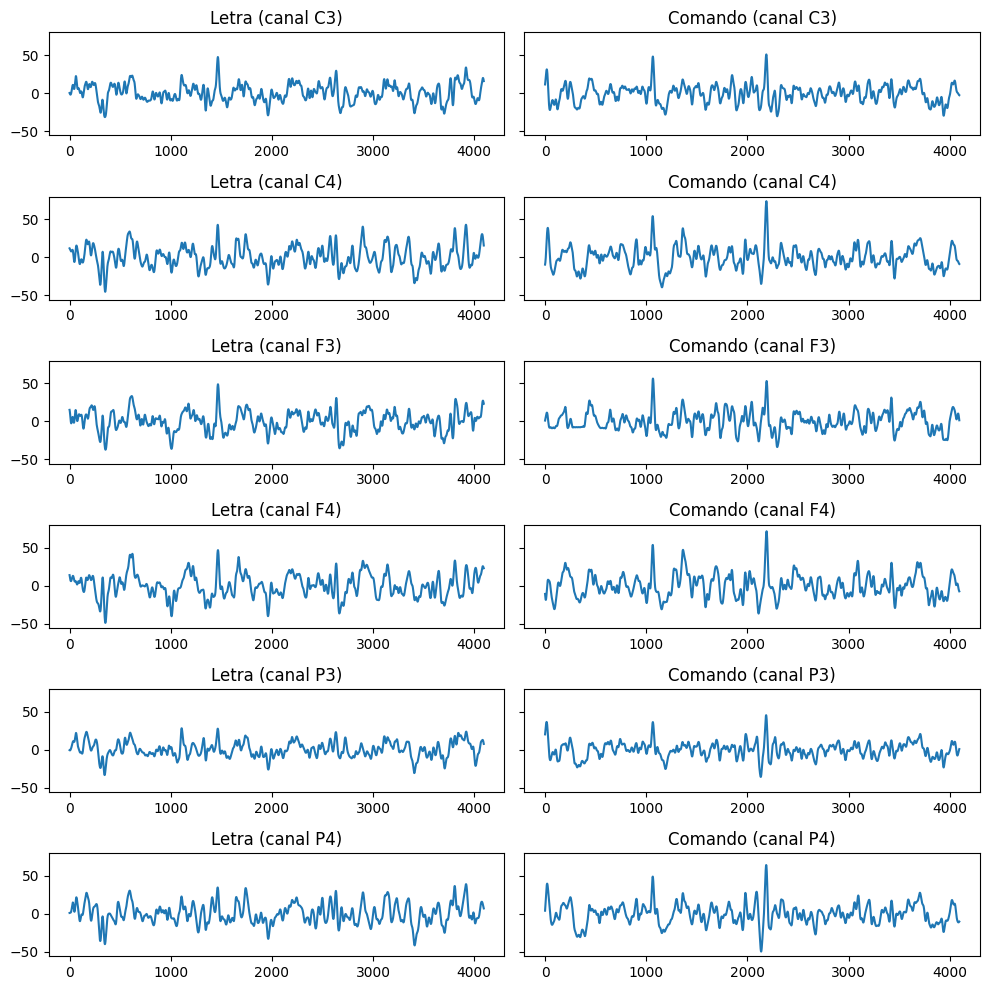

In [5]:
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(10,10), sharey=True)

letter_sample = df_train[y_train.is_letter.values].head(1)
command_sample = df_train[~(y_train.is_letter).values].head(1)

ix_channel = 0
for ix_row in range(6):
    for ix_col in range(2):
        label = "Letra" if ix_col == 0 else "Comando"
        channel_cols = [c for c in df_train.columns if channels[ix_channel] in c]
        axes[ix_row, ix_col].set_title(f"{label} (canal {channels[ix_channel]})")
        if label == "Letra":
            axes[ix_row, ix_col].plot(letter_sample[channel_cols].values[0])
        else:
            axes[ix_row, ix_col].plot(command_sample[channel_cols].values[0])

    ix_channel += 1
plt.tight_layout()

# Extracción de características

Definimos las funciones para procesar las señales de EEG y extraer las características que verá el clasificador.

### Características

Se procesa la señal temporal para extraer seis estadísticos por cada canal: media, desvío estandar, mínimo, máximo, curtosis y el coeficiente de asimetría de Fisher.

In [6]:
X_train = pd.DataFrame()
X_test = pd.DataFrame()

In [7]:
statistics = [np.mean, np.std, np.min, np.max, kurtosis, skew]

for channel in channels:
    channel_columns = [c for c in df_train.columns if channel in c]
    for stat in statistics:
        col_name = f'{channel}_{stat.__name__}'
        X_train[col_name] = stat(df_train[channel_columns], axis=1)
        X_test[col_name] = stat(df_test[channel_columns], axis=1)

# Definición y entrenamiento del clasificador

Definimos y entrenamos un perceptrón multicapa al que le ingresan las características normalizadas.

In [8]:
X_train.head()

,C3_mean,C3_std,C3_amin,C3_amax,C3_kurtosis,C3_skew,C4_mean,C4_std,C4_amin,C4_amax,...,P3_amin,P3_amax,P3_kurtosis,P3_skew,P4_mean,P4_std,P4_amin,P4_amax,P4_kurtosis,P4_skew
0,0.592634,11.351732,-31.499783,47.372715,0.426197,0.111990,0.604357,14.145288,-45.305195,42.717160,...,-33.212685,28.271402,0.238066,-0.025419,0.659807,13.213316,-41.381460,39.135845,0.276971,0.120186
1,-0.497312,11.537114,-30.401037,50.835106,1.203746,0.265640,-0.242295,14.146621,-39.504370,73.676860,...,-35.639904,45.403046,1.862791,0.228741,-0.063983,13.297825,-49.468964,64.219980,1.937848,0.324516
2,-0.302712,13.316039,-33.753304,50.472828,0.959127,0.625852,-0.243741,15.149677,-47.240406,64.889840,...,-46.131695,46.043100,1.615524,0.442224,-0.215178,14.599125,-58.790850,57.879917,1.773842,0.316615
3,-0.078032,10.122394,-26.325730,52.605140,1.945580,0.524698,-0.096921,11.399675,-36.130260,59.071144,...,-21.457817,38.882786,1.349970,0.558519,-0.131994,10.557227,-28.362791,52.332664,1.570742,0.604802
4,0.209391,12.748181,-36.639070,49.336784,0.173969,0.052076,0.126516,16.074364,-38.013794,49.909466,...,-42.613880,42.227440,0.129564,0.185935,0.116332,16.474498,-44.715980,47.845340,-0.154902,0.325327


In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report

# feature scaling
scaler = StandardScaler()

# base classifier
clf = GradientBoostingClassifier(
    n_estimators=100,
    max_depth=5,
    random_state=RANDOM_SEED)
# classifier
pipe = make_pipeline(scaler, clf)

In [10]:
# training
pipe.fit(X_train, y_train.is_letter.values)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(max_depth=5, random_state=24))])

In [11]:
y_pred_train = pipe.predict(X_train)

In [12]:
print(classification_report(y_train.is_letter.values, y_pred_train))

              precision    recall  f1-score   support

       False       0.93      0.94      0.93      2353
        True       0.92      0.91      0.91      1919

    accuracy                           0.92      4272
   macro avg       0.92      0.92      0.92      4272
weighted avg       0.92      0.92      0.92      4272



# Generar el archivo de predicciones

Realizamos las predicciones con nuestro modelo ya entrenado.

In [13]:
predicted_labels = pipe.predict(X_test)

Luego escribimos las predicciones junto a los ids en un archivo (`"submission.csv"`).

In [14]:
df_test_predictions = pd.DataFrame({'is_letter' : predicted_labels})
df_test_predictions.index = df_test.index + 1
df_test_predictions.index.names = ['ID']

df_test_predictions.to_csv("submission.csv")